In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox



In [2]:
# DOWNLOADING DATA
# the ticker symbol
ticker_symbol = "INR=X"
start_date = "2015-01-01" #the start date (took more or less 10 years, so 2015)


inr_data = yf.download(ticker_symbol, start=start_date)

# Display the first few rows to confirm the download
print(inr_data.head())

/var/folders/4p/23m263753jx7n8lstr62j07h0000gn/T/ipykernel_65366/332708241.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  inr_data = yf.download(ticker_symbol, start=start_date)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open Volume
Ticker          INR=X      INR=X      INR=X      INR=X  INR=X
Date                                                         
2015-01-01  63.028000  63.090000  63.028000  63.028000      0
2015-01-02  63.028000  63.459999  62.900002  63.090000      0
2015-01-05  63.278000  63.480000  63.169998  63.278000      0
2015-01-06  63.338001  63.618000  63.250000  63.338001      0
2015-01-07  63.568001  63.580002  63.150002  63.470001      0


In [3]:
# CALCULATING LOG-RETURNS
#r_t  = ln(P_t / P_(t-1))
inr_data['log_return'] = np.log(inr_data['Close'] / inr_data['Close'].shift(1))
inr_data.dropna(inplace=True) #removing NaN values that result from the shift operation

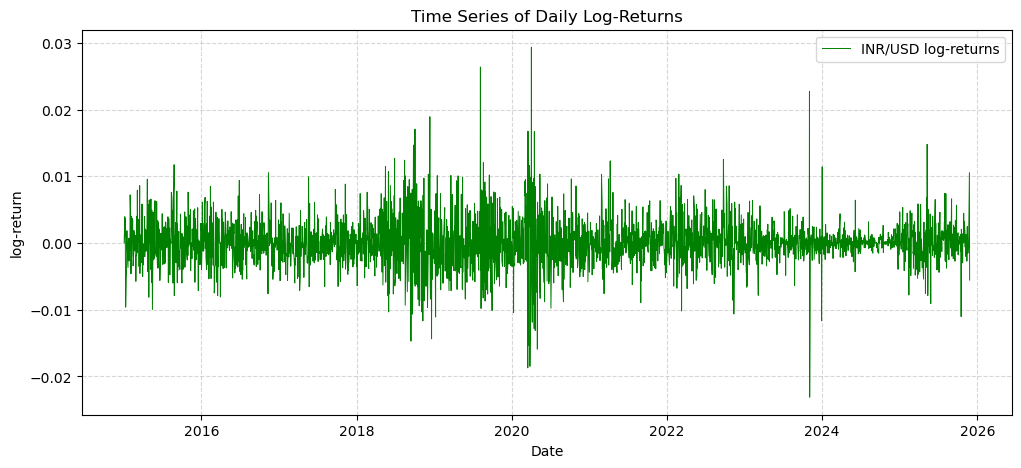

In [4]:
# PLOTTING LOG-RETURNS TIME SERIES 
plt.figure(figsize=(12, 5))
plt.plot(inr_data.index, inr_data['log_return'], label='INR/USD log-returns', color='green', linewidth=0.7)
plt.title('Time Series of Daily Log-Returns')
plt.ylabel('log-return')
plt.xlabel('Date')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.show()


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4p/23m263753jx7n8lstr62j07h0000gn/T/ipykernel_65366/1537104161.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, p, 'k', linewidth=2, label=f'normal fit: ($\mu$={mu:.4f}, $\sigma$={sigma:.4f})')
/var/folders/4p/23m263753jx7n8lstr62j07h0000gn/T/ipykernel_65366/1537104161.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, p, 'k', linewidth=2, label=f'normal fit: ($\mu$={mu:.4f}, $\sigma$={sigma:.4f})')


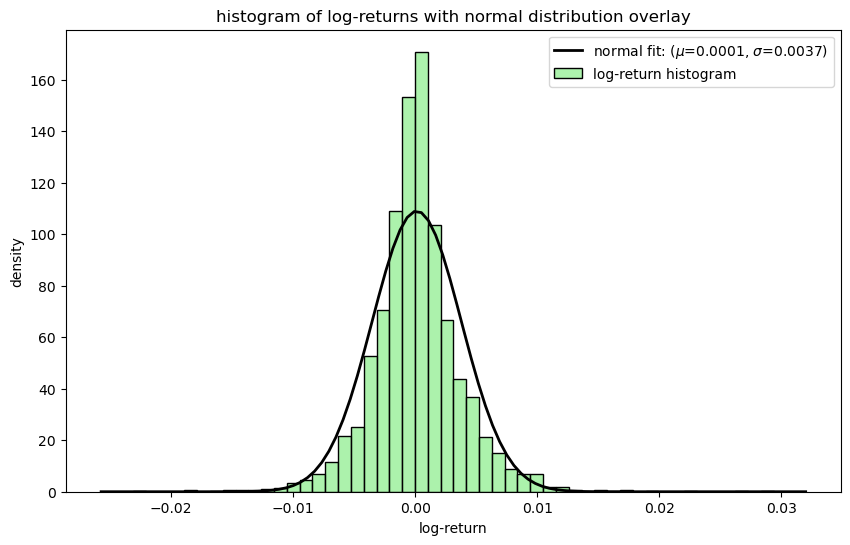

In [5]:
# HISTOGRAM OF LOG-RETURNS + NORMALITY TEST
returns = inr_data['log_return']

plt.figure(figsize=(10, 6))
sns.histplot(returns, bins=50, kde=False, stat='density', color='lightgreen', label='log-return histogram')

#fitting a normal distribution to the data
mu, sigma = norm.fit(returns)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)

#plotting the fitted normal distribution
plt.plot(x, p, 'k', linewidth=2, label=f'normal fit: ($\mu$={mu:.4f}, $\sigma$={sigma:.4f})')
plt.title('histogram of log-returns with normal distribution overlay')
plt.xlabel('log-return')
plt.ylabel('density')
plt.legend()
plt.show()


In [7]:
# JARQUE-BERA NORMALITY TEST
jb_test = jarque_bera(returns)
print('jarque-bera normality test')
print(f'JB statistic: {jb_test.statistic:.4f}')
print(f'p-value: {jb_test.pvalue:.4e}') #using scientific notation for small p-values

if jb_test.pvalue < 0.05:
    print('reject the null hypothesis of normal distribution (p-value < 0.05)')
else:
    print('cant reject the null hypothesis of normal distribution')
print('-'*30)

jarque-bera normality test
JB statistic: 3595.8444
p-value: 0.0000e+00
reject the null hypothesis of normal distribution (p-value < 0.05)
------------------------------


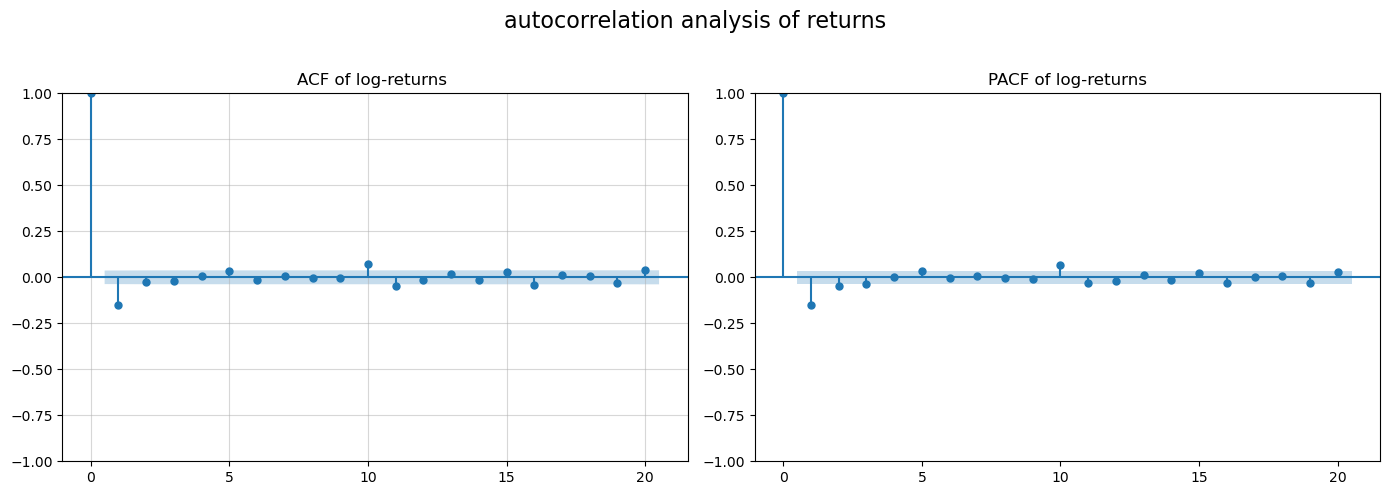

ljung-box test on log-returns
       lb_stat     lb_pvalue
10   85.433123  4.287555e-14
20  110.638075  1.502240e-14

*If p-values are high (>0.05), there is no significant autocorrelation*
------------------------------


In [8]:
# PLOTTING THE ACF FOR LOG-RETURNS AND SQUARED LOG-RETURNS
## 1. ACF and PACF for log-returns (r_t)
fig, axes = plt.subplots(1, 2, figsize=(14,5))

#ACF 
plot_acf(returns, lags = 20, ax=axes[0], title='ACF of log-returns ')
axes[0].grid(True, alpha = 0.5)
#PACF
plot_pacf(returns, lags = 20, ax=axes[1], title='PACF of log-returns')
axes[0].grid(True, alpha =0.5)

plt.suptitle('autocorrelation analysis of returns', fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Ljung-Box test for autocorrelation in returns
lb_test_r = acorr_ljungbox(returns, lags=[10,20], return_df=True)
print('ljung-box test on log-returns')
print(lb_test_r)
print('\n*If p-values are high (>0.05), there is no significant autocorrelation*')
print('-' * 30)

In [ ]:
# REJECT THE NULL HYPOTHESIS
# The usual assumption for financial returns is that they exhibit no significant linear autocorrelation 
# (they are close to a white noise process), which is a key property of an efficient market.

# the result indicates that he log-returns are NOT white noise; there is a significant 
# linear dependence in the exchange rate series

# THUS, cant proceed immediately to modelling the variance (sigma^2) using GARCH on the raw returns

# the CORRECTION -> adding a mean equation:
# It is necessary to filter out the linear dependence in the mean of the return series.
# This is done by fitting an ARMA model to the returns

# MODELLING PROCESS: Return series (r_t) => ARMA (p,q) => Residuals (e_t)
# GARCH model will then be applied to the residuals (e_t) of the ARMA model, as these 
# residuals are the UNPREDICTABLE part of the returns and should be closer to the white noise (in the mean)


In [ ]:
# DETERMINING THE ARMA ORDER
# re-examining the ACF and PACF plots to determine appropriate orders (p and q) for the ARMA

# ACF: spike at Lag 1, Lag 10 (very minor -> can initially ignore for parsimony)
# a single significant spike immediately cuts off in the ACF, suggesting MA(1)

# PACF: spike at Lag 1 -> cuts off, suggesting AR(1)

# => ARMA (1, 1)

In [9]:
from statsmodels.tsa.arima.model import ARIMA

In [10]:
# The ARIMA model in statsmodels handles ARMA by setting the 'i' (differencing) order to 0.
# order=(p, d, q) -> AR(p), I(d), MA(q)
# For ARMA(1, 1), the order is (1, 0, 1)

arma_model = ARIMA(returns, order=(1, 0, 1))
arma_results = arma_model.fit()

print(arma_results.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 2837
Model:                 ARIMA(1, 0, 1)   Log Likelihood               11927.731
Date:                Tue, 25 Nov 2025   AIC                         -23847.462
Time:                        15:34:23   BIC                         -23823.660
Sample:                             0   HQIC                        -23838.876
                               - 2837                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   5.66e-05      2.149      0.032    1.07e-05       0.000
ar.L1          0.1897      0.074      2.547      0.011       0.044       0.336
ma.L1         -0.3486      0.073     -4.804      0.0


ljung-box test on ARMA(1, 1) residuals
      lb_stat  lb_pvalue
10  16.610840   0.083431
20  34.478233   0.023066

at least one p-value is <= 0.05. linear dependence remains. consider a higher ARMA model
------------------------------------------------------------


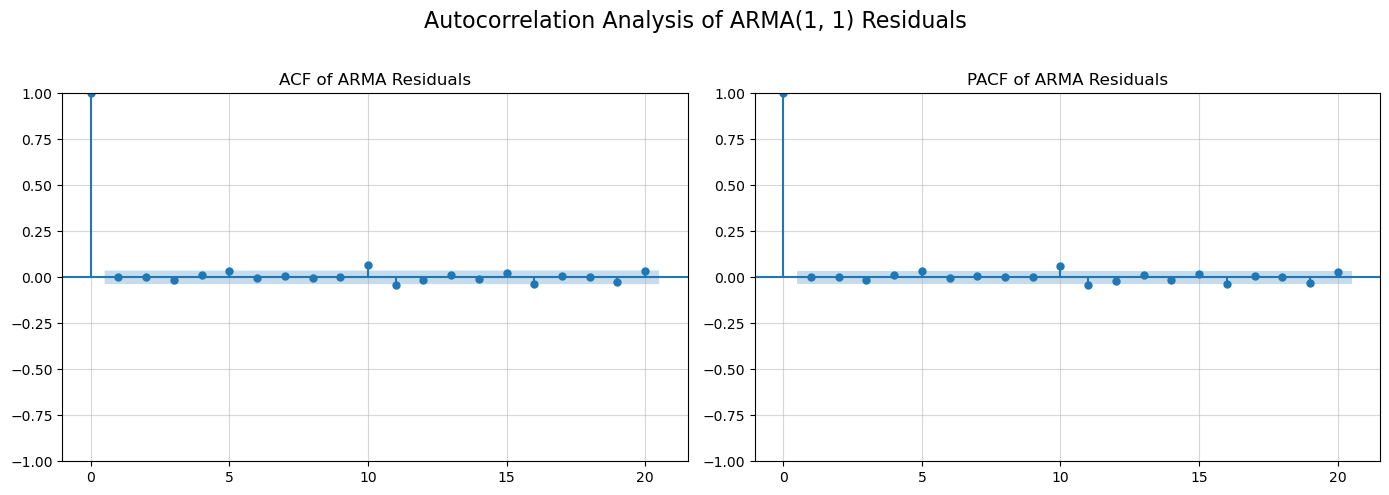

In [11]:
# EXTRACTING AND CHECKING RESIDUALS
residuals = arma_results.resid

#LB-test on residuals
lb_test_resid = acorr_ljungbox(residuals, lags=[10,20], return_df=True)
print('\nljung-box test on ARMA(1, 1) residuals')
print(lb_test_resid)

if all(lb_test_resid['lb_pvalue'] > 0.05):
    print('\nresiduals appear to be white noise (no significant autocorrelation)')
    print('can now proceed to model the variance using GARCH')
else:
    print('\nat least one p-value is <= 0.05. linear dependence remains. consider a higher ARMA model')
print('-' * 60)

# plotting acf and pacf for residuals
fig, axes = plt.subplots(1, 2, figsize=(14,5))
plot_acf(residuals, lags=20, ax=axes[0], title='ACF of ARMA Residuals')
axes[0].grid(True, alpha=0.5)

plot_pacf(residuals, lags=20, ax=axes[1], title='PACF of ARMA Residuals')
axes[1].grid(True, alpha=0.5)

plt.suptitle('Autocorrelation Analysis of ARMA(1, 1) Residuals', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
#Since the ARMA(1,1) only solved the Lag 1 dependence, 
# need a new model that addresses the remaining dependence, especially at Lag 10.

# try AUTOMATIC ARMA selection

In [12]:
from pmdarima import auto_arima
from arch import arch_model
import warnings
warnings.filterwarnings("ignore") # Suppress warnings

In [13]:
best_model = auto_arima(
    returns,
    d=0,             # Integrated order d=0 for ARMA
    max_p=5,
    max_q=5,
    m=1,             # m=1 for non-seasonal
    seasonal=False,
    stepwise=True,   # Faster search
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='bic' # Prioritize BIC for more parsimonious models
)

print(f"\nOptimal ARMA Order: ARIMA{best_model.order}")
print(best_model.summary())


Optimal ARMA Order: ARIMA(0, 0, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2837
Model:               SARIMAX(0, 0, 1)   Log Likelihood               11924.072
Date:                Tue, 25 Nov 2025   AIC                         -23844.144
Time:                        15:34:47   BIC                         -23832.243
Sample:                             0   HQIC                        -23839.851
                               - 2837                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1572      0.012    -13.128      0.000      -0.181      -0.134
sigma2      1.308e-05   1.81e-07     72.389      0.000    1.27e-05    1.34e-05
Ljung-Box (L1) (

In [15]:
# EXTRACTING AND CHECKING THE RESIDUALS
residuals_final = pd.Series(best_model.resid(), index=returns.index)

lb_test_residuals_final = acorr_ljungbox(residuals_final, lags=[10, 20], return_df=True)
print("\nFinal Ljung-Box Test on Residuals")
print(lb_test_residuals_final)

if all(lb_test_residuals_final['lb_pvalue'] > 0.05):
    print("Residuals are confirmed as white noise in the mean.")
else:
    print("Residuals still contain linear dependence. Proceed with caution.")
print("-" * 60)


Final Ljung-Box Test on Residuals
      lb_stat  lb_pvalue
10  19.775041   0.031454
20  37.689810   0.009661
Residuals still contain linear dependence. Proceed with caution.
------------------------------------------------------------
